# ****📜 About this dataset****
# ****Feature info****

   * Age: age of the patient [years]
   * Sex: sex of the patient [M: Male, F: Female]
   * ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
   * RestingBP: resting blood pressure [mm Hg]
   * Cholesterol: serum cholesterol [mm/dl]
   * FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
   * RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
   * MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
   * ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
   * Oldpeak: oldpeak = ST [Numeric value measured in depression]
   * ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
   * HeartDisease: output class [1: heart disease, 0: Normal]



In [2]:
import pandas as pd
data = pd.read_csv("/kaggle/input/heart-failure-prediction/heart.csv")

In [3]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
data.info

<bound method DataFrame.info of      Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
0     40   M           ATA        140          289          0     Normal   
1     49   F           NAP        160          180          0     Normal   
2     37   M           ATA        130          283          0         ST   
3     48   F           ASY        138          214          0     Normal   
4     54   M           NAP        150          195          0     Normal   
..   ...  ..           ...        ...          ...        ...        ...   
913   45   M            TA        110          264          0     Normal   
914   68   M           ASY        144          193          1     Normal   
915   57   M           ASY        130          131          0     Normal   
916   57   F           ATA        130          236          0        LVH   
917   38   M           NAP        138          175          0     Normal   

     MaxHR ExerciseAngina  Oldpeak ST_Slope  HeartDisea

In [5]:
data.nunique()

Age                50
Sex                 2
ChestPainType       4
RestingBP          67
Cholesterol       222
FastingBS           2
RestingECG          3
MaxHR             119
ExerciseAngina      2
Oldpeak            53
ST_Slope            3
HeartDisease        2
dtype: int64

In [6]:
#Checking if the dataset is skewed
print(f"% of 'No' in target column {(data['HeartDisease'].value_counts()[0]/data['HeartDisease'].count())*100}%")
print(f"% of 'Yes' in target column {(data['HeartDisease'].value_counts()[1]/data['HeartDisease'].count())*100} %")

% of 'No' in target column 44.66230936819172%
% of 'Yes' in target column 55.33769063180828 %


In [7]:
ohe_features = ['ChestPainType', 'RestingECG','ST_Slope']
categorical_features = ['ChestPainType', 'RestingECG','ST_Slope', 'Sex', 'FastingBS', 'ExerciseAngina']

<Figure size 800x550 with 0 Axes>

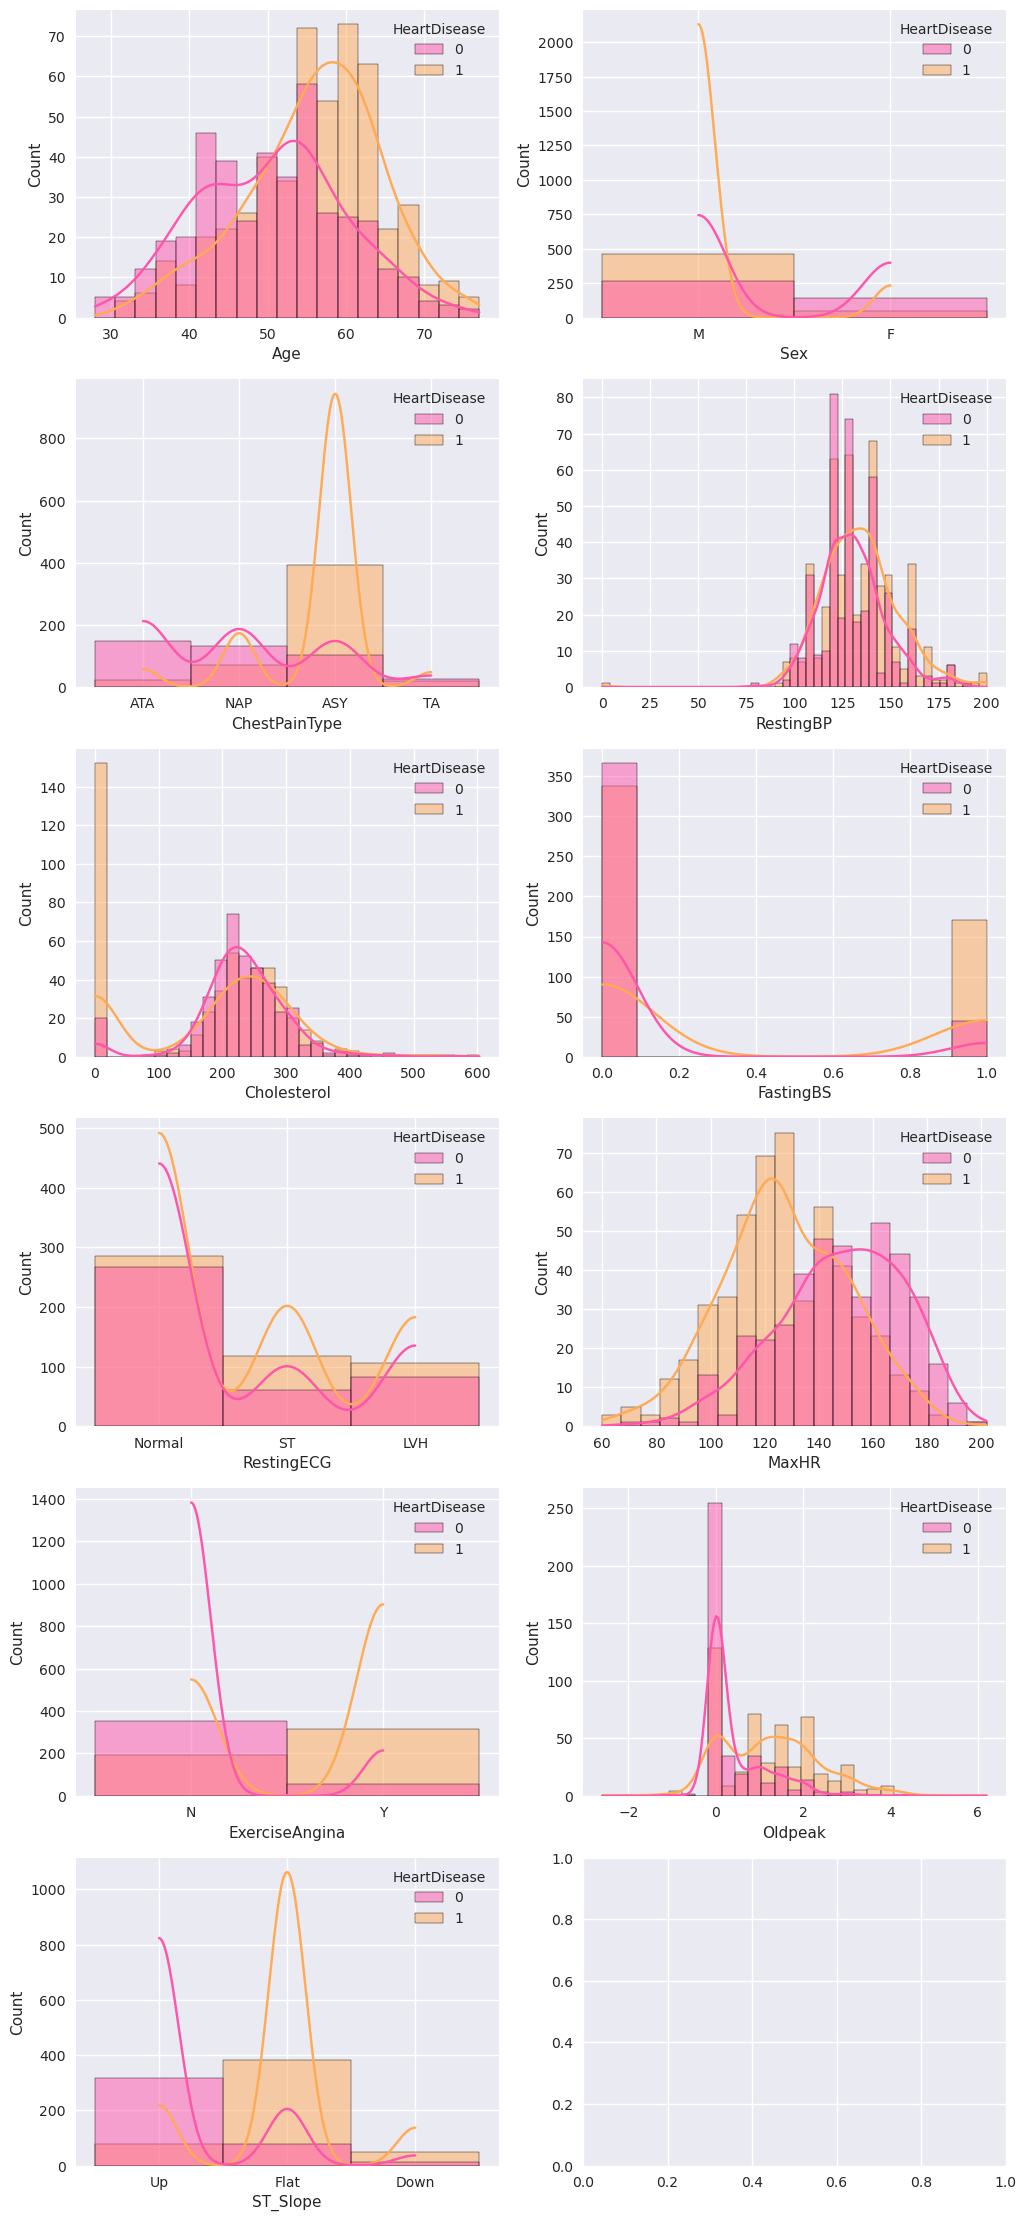

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn")
plt.subplots_adjust(hspace=0.3)
color = 'spring'

fig, axs = plt.subplots(6, 2, figsize=(12,28))
i=1
for feature in data.columns:
    if feature not in ["HeartDisease"]:
        plt.subplot(6,2,i)
        sns.histplot(data=data, x=feature, kde=True, palette=color, hue='HeartDisease')
        i+=1

****Checking for NaN****

In [9]:
data.isnull().sum()
# No null values :)

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

# ****Encoding features****

In [10]:
import numpy as np

#Label encoding catgegorical features
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
for i in ohe_features:
    data[i] = label_encoder.fit_transform(data[i])
    
data['Sex'] = label_encoder.fit_transform(data['Sex'])

# Ordinal Encoding 'ExerciseAngina' feature because it has 'Y' and 'N'
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder(categories = [['N','Y']])
oe = ordinal_encoder.fit(data[['ExerciseAngina']])
data['ExerciseAngina'] = oe.transform(data[['ExerciseAngina']])

#Creating a separate dataframe of categoricalfeatures for one hot encoding
ohe_features_data = data[ohe_features]

not_cat_ohe_features = list(set(categorical_features) - set(ohe_features))
cat_features_data = data[not_cat_ohe_features]
cat_features_data = np.array(cat_features_data)

#One hot encoding categorical data
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
ohe_data = ohe.fit_transform(ohe_features_data).toarray() #one hot encoded array

In [11]:
# array containing categorical data
new_cat_data = np.hstack((cat_features_data, ohe_data))

#Getting the continuous features for scaling
data2 = data.drop(categorical_features, axis = 'columns') #dropping categorical features
data2 = data2.drop('HeartDisease',axis = 'columns') #Dropping target column
data2 = np.array(data2) # converting our data containing continuous features into numpy array

**Scaling Data**

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() #uses normal curve to scale the data as follows
"""
z =    x - mean
    --------------
    std. deviation
"""
scaled_data = scaler.fit_transform(data2)

# ****Splitting our data for training, cross-validation and testing****

In [13]:
X = np.hstack((scaled_data, new_cat_data)) # Independent variable
# np.hstack() joins two numpy arrays
y = np.array(data['HeartDisease']) # Dependent variable

In [14]:
# Splitting our data using sklearn.train_test_split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 44)

#Splitting the test data in 50-50 ratio for cross validation
X_cv, X_test, y_cv, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 44)
for i in ['X_train', 'y_train', 'X_cv', 'y_cv', 'X_test', 'y_test']:
    print(f'Size of {i} = {locals()[i].shape}')


Size of X_train = (734, 18)
Size of y_train = (734,)
Size of X_cv = (92, 18)
Size of y_cv = (92,)
Size of X_test = (92, 18)
Size of y_test = (92,)


# Trying different learning algorithms

# ****Logistic Regression****

In [16]:
"""
Sigmoid function is defined as follows :

g(z) =     1
       ---------
       1 + e^(-z)
"""
def sigmoid_function(z):
    return 1/(1+np.exp(-z))

In [17]:
def cost_function(X, y, w, b):
    m = X.shape[0] #number of training examples
    cost = 0.0 
    
    for i in range(m):
        z_i = np.dot(X[i], w.reshape(-1,1)) + b
        f_wb_i = sigmoid_function(z_i)
        cost += (-y[i]*np.log(f_wb_i) -(1-y[i])*np.log(1-f_wb_i))
    cost /= m
    return cost

Degree = 1

Training cost = [0.31455026]
Cross validation cost = [0.30172886]
Score = 83.69565217391305

Degree = 2

Training cost = [0.29740945]
Cross validation cost = [0.27495266]
Score = 86.95652173913044

Degree = 3

Training cost = [0.25586506]
Cross validation cost = [0.36347345]
Score = 85.86956521739131



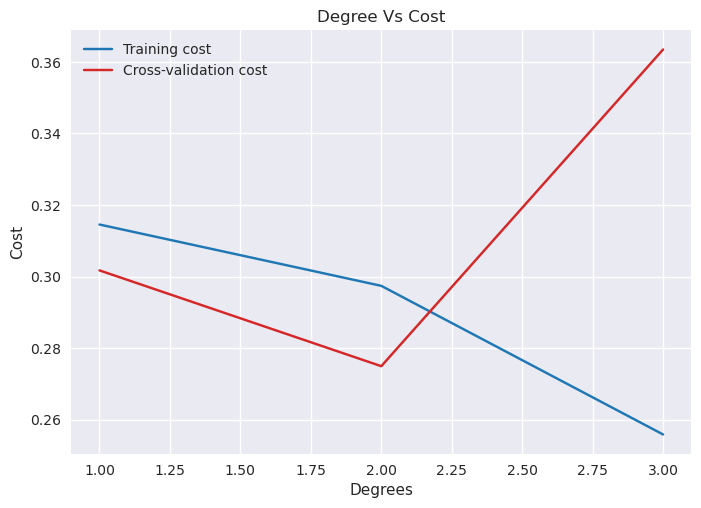

In [18]:
from sklearn.linear_model import LogisticRegression

degrees = [1, 2, 3]
training_costs = list()
cv_costs = list()
parameters = list()
for degree in degrees:
    poly_features_train = get_polynomial_features(X_train, degree)
    poly_features_cv = get_polynomial_features(X_cv, degree)
    clf = LogisticRegression(max_iter = 1000000)
    clf.fit(poly_features_train, y_train)
    weights = clf.coef_ 
    bias = clf.intercept_
    parameters.append([weights,bias])
    #print(f'Weights = {weights}\nBias = {bias}')
    J_train = cost_function(poly_features_train, y_train, weights, bias) # training cost
    training_costs.append(J_train)
    print(f'Degree = {degree}\n')
    print(f'Training cost = {J_train}')
    J_cv = cost_function(poly_features_cv, y_cv, weights, bias) #cross-validation cost
    cv_costs.append(J_cv)
    print(f'Cross validation cost = {J_cv}')
    print(f'Score = {clf.score(poly_features_cv, y_cv)*100}\n')
    
plt.style.use("seaborn")
plt.xlabel("Degrees")
plt.ylabel("Cost")
plt.title("Degree Vs Cost")
plt.plot(degrees,training_costs, color ='tab:blue')
plt.plot(degrees,cv_costs, color ='tab:red')
plt.legend(["Training cost", "Cross-validation cost"])
plt.show()

There's a sharp decrease in the training cost after degree = 2, but there's also a sharp increase in the cross-validation cost after degree = 2. This shows that the model is **overfitting** after 2nd degree.
So, we choose degree = 2 for our logistic regression model.

In [19]:
best_degree = 2
final_parameters = parameters[1] # considering the parameters of degree = 2 as final parameters

In [20]:
# Finally evaluating our model using test set

poly_features_test = get_polynomial_features(X_test, best_degree)
poly_features_train = get_polynomial_features(X_train, best_degree)
clf = LogisticRegression(max_iter = 100000)
clf.fit(poly_features_train, y_train)
weights = final_parameters[0]
bias = final_parameters[1]
J_test = cost_function(poly_features_test, y_test, weights, bias)
print(f'Test set cost = {J_test}')
print(f'Score = {clf.score(poly_features_test, y_test)*100} %')

Test set cost = [0.51264706]
Score = 81.52173913043478 %


# **Neural Network**

In [21]:
def cost_function_nn(X, y):
    m = X.shape[0] # number of training examples
    cost = 0.0
    for i in range(m):
        cost += -y[i]*np.log(X[i]) - (1-y[i])*(np.log(1-X[i]))
    cost /= m
    return cost
        

In [22]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import L2

"""
Choosing the number of neurons in the hidden layers as:

N =        N_s
    -----------------
    (2 * (N_i + N_o))

Where,
N = number of neurons
N_s = number of samples
N_i = number of neurons in the input layer
N_o = number of neurons in the output layer
"""
def nn(X_train, y_train, X_cv, y_cv, epochs, flag = 0):
    model = Sequential([
        Dense(units = 19, activation  = 'relu', kernel_regularizer = L2(1e-3)),
        Dense(units = 1, activation = 'linear', kernel_regularizer = L2(1e-3)),
    ])

    from tensorflow.keras.losses import BinaryCrossentropy

    model.compile(
        loss = BinaryCrossentropy(from_logits = True),
        optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-2)
    )

    model.fit(X_train, y_train, epochs = epochs, verbose = 0)

    logits = model(X_train)
    f_x = tf.nn.sigmoid(logits)
    J_train = cost_function_nn(f_x, y_train)
    logits_cv = model(X_cv)
    f_x_cv = tf.nn.sigmoid(logits_cv)
    J_cv = cost_function_nn(f_x_cv, y_cv)
    
    if flag==1:
        return np.array(f_x_cv)
    else:
        return J_train, J_cv
        

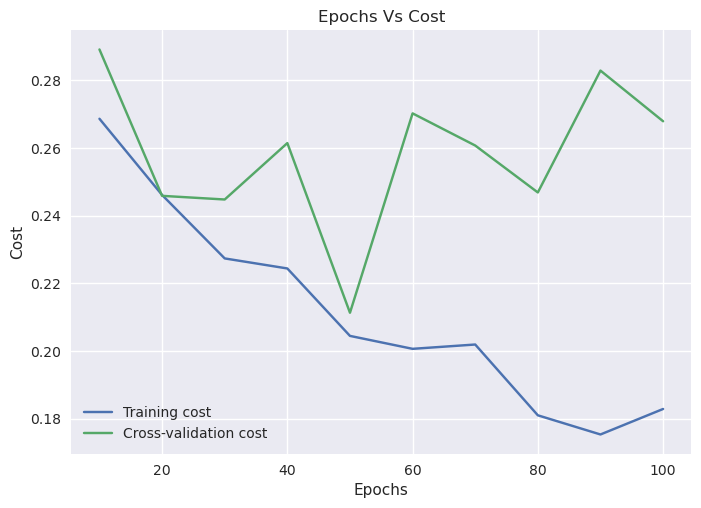

In [23]:
epochs = list(range(10,101, 10))
J_trains, J_cvs = list(), list()
for no_of_epochs in epochs:
    j_train, j_cv = nn(X_train, y_train, X_cv, y_cv, no_of_epochs)
    J_trains.append(j_train)
    J_cvs.append(j_cv)
plt.style.use("seaborn")
plt.title("Epochs Vs Cost")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.plot(epochs, J_trains)
plt.plot(epochs, J_cvs)
plt.legend(["Training cost", "Cross-validation cost"])
plt.show()

After 40 epochs the cross-validation error is increasing, so we're choosing 40 epochs for our model.

In [24]:
n_epochs = 40

In [25]:
def accuracy_checker(choice, n_epochs):
    if choice==1:
        print('Cross-validation set ',end='')
        y_pred = nn(X_train, y_train, X_cv, y_cv, n_epochs, 1)
        y_true = y_cv
    else:
        print('Testing set ',end='')
        y_pred = nn(X_train, y_train, X_test, y_test, n_epochs, 1)
        y_true = y_test
    correct_predictions = 0
    m = y_pred.shape[0]
    for i in range(m):
        y_pred[i] = 0 if y_pred[i]<0.5 else 1
        if y_pred[i] == y_true[i]:
            correct_predictions += 1
    print(f'Accuracy : {(correct_predictions/(i+1))*100}')

In [26]:
accuracy_checker(1, n_epochs)
accuracy_checker(2, n_epochs)

Cross-validation set Accuracy : 92.3913043478261
Testing set Accuracy : 84.78260869565217


# **Decision Trees**

In [27]:
def accuracy(y_pred,y_true):
    m = y_pred.shape[0]
    correct_predictions = 0
    for i in range(m):
            if y_pred[i] == y_true[i]:
                correct_predictions += 1
    print(f'Accuracy : {(correct_predictions/(i+1))*100}')

In [28]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(criterion = "entropy")
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_cv)
y_pred_test = rf_clf.predict(X_test)
print('Cross-validation ',end='')
accuracy(y_pred, y_cv)
print('\nTest set ',end='')
accuracy(y_pred_test, y_test)

Cross-validation Accuracy : 90.21739130434783

Test set Accuracy : 83.69565217391305


In [29]:
from xgboost import XGBClassifier
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_cv)
y_pred_test = xgb_clf.predict(X_test)
print('Cross-validation ',end='')
accuracy(y_pred, y_cv)
print('\nTest set ',end='')
accuracy(y_pred_test, y_test)

Cross-validation Accuracy : 85.86956521739131

Test set Accuracy : 79.34782608695652
